# **Fine-Tuning LLaMA-3 for Psychology Question Answering Using LoRA and Unsloth**

This step-by-step guide walks you through the fine-tuning process of the LLaMA-3 model for psychology question answering using LoRA (Low-Rank Adaptation) and Unsloth. By following this notebook, you'll learn how to efficiently adapt a large language model for a specialized task in psychology. Whether you're a machine learning enthusiast or a psychology researcher, this guide provides a practical approach to creating a robust question-answering system.


**Step 1: Install Necessary Libraries**



The following cell installs essential libraries for fine-tuning.

* **Unsloth:** A framework for efficient model management and fine-tuning.

* **Xformers:** Optimizes attention mechanisms for handling large sequences.

* **TRL (Transformers Reinforcement Learning):** Provides tools for reinforcement learning-based model tuning.

* **PEFT (Parameter Efficient Fine-Tuning):** Reduces memory requirements during fine-tuning by updating only a subset of model parameters.

* **BitsAndBytes:** Enables efficient quantization techniques, such as 4-bit precision.




Using these libraries ensures our environment is equipped for both memory-efficient and effective LLM fine-tuning.

In [ ]:
%%capture
!pip install "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"
!pip install --no-deps xformers trl peft accelerate bitsandbytes

**Step 2: Load Pretrained Model and Tokenizer**


**What is Unsloth and What Is It Used For?**

Unsloth is a streamlined framework designed to simplify and optimize the process of working with large language models (LLMs). Think of it as your ultimate toolkit for fine-tuning and deploying LLMs with efficiency and ease.

In [ ]:
from unsloth import FastLanguageModel
import torch
max_seq_length = 2048
dtype = None
load_in_4bit = True

**Why Did We Load the Model from Unsloth?**

We loaded the model from Unsloth because it provides a pre-configured, optimized environment tailored for efficient LLM fine-tuning and deployment. Here’s why this choice makes sense:

* **Memory Efficiency:** Unsloth’s models are pre-quantized, often using techniques like 4-bit precision, which significantly reduces memory requirements without compromising performance.
* **Long-Context Support:** The framework incorporates advanced features like RoPE (Rotary Position Embedding) scaling, making it ideal for tasks requiring long input sequences.
* **Fine-Tuning Ready:** Models from Unsloth are designed with parameter-efficient techniques in mind, ensuring smooth integration with LoRA and QLoRA.
* **Ease of Use:** By handling complex setups internally, Unsloth eliminates the need for extensive manual configurations, saving time and reducing errors.

The model loaded here is "unsloth/llama-3-8b-bnb-4bit," a lightweight yet powerful variant for tasks requiring large language models.

In [ ]:
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/llama-3-8b-bnb-4bit",
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2024.12.2: Fast Llama patching. Transformers:4.46.2.
   \\   /|    GPU: Tesla T4. Max memory: 14.748 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu121. CUDA: 7.5. CUDA Toolkit: 12.1. Triton: 3.1.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.28.post3. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/5.70G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/198 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/50.6k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

**Step 3: Apply Parameter-Efficient Fine-Tuning (LoRA)**



Parameter-Efficient Fine-Tuning (PEFT) is a more efficient form of instruction-based fine-tuning. Full LLM fine-tuning is resource-intensive, demanding considerable computational power, memory, and storage. PEFT addresses this by updating only a select set of parameters while keeping the rest frozen. This reduces the memory load during training and prevents the model from forgetting previously learned information. PEFT is particularly useful when fine-tuning for multiple tasks. Among the common techniques to achieve PEFT, LoRA and QLoRA are widely recognized for their effectiveness.

**What is LoRA?**

LoRA (Low-Rank Adaptation) is a method that fine-tunes two smaller matrices instead of the entire weight matrix of a pre-trained LLM. These smaller matrices form a LoRA adapter, which is then applied to the original LLM. The fine-tuned adapter is much smaller in size compared to the original model, often only a small percentage of its size. During inference, this LoRA adapter is combined with the original LLM.

In our notebook, LoRA adapters are applied:

* **Target Modules:** Defines which parts of the model are fine-tuned, like query, key, and value projections.
* **LoRA Alpha & Dropout:** Control the adaptation strength and regularization.
* **Gradient Checkpointing:** Reduces memory usage during training by recomputing intermediate states.
* **Random State:** Ensures reproducibility.

This step ensure that wwe are only modifying specific parameters (around 10% of all parameters).

In [ ]:
model = FastLanguageModel.get_peft_model(
    model,
    r = 16,
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 16,
    lora_dropout = 0,
    bias = "none",    *
    use_gradient_checkpointing = "unsloth",
    random_state = 3407,
    use_rslora = False,
    loftq_config = None,
)

Unsloth 2024.12.2 patched 32 layers with 32 QKV layers, 32 O layers and 32 MLP layers.


In [ ]:
model

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): LlamaForCausalLM(
      (model): LlamaModel(
        (embed_tokens): Embedding(128256, 4096, padding_idx=128255)
        (layers): ModuleList(
          (0-31): 32 x LlamaDecoderLayer(
            (self_attn): LlamaAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=4096, out_features=4096, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Identity()
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=16, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=16, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()
              )
              (k_proj): lor


**Step 4: Load and Preprocess the Dataset for Fine-Tuning**

**What is an LLM Dataset?**

An LLM dataset is a collection of text data used for training and fine-tuning language models. These datasets contain various types of text, such as questions, answers, documents, or dialogues, and are tailored for specific tasks or domains. The quality of the dataset significantly influences the model's performance and accuracy.

**Types of Datasets for Fine-Tuning LLMs**

* **Text Classification Datasets:** These datasets help train models to categorize text into predefined categories like sentiment analysis, topic classification, or spam detection.
* **Text Generation Datasets:** These consist of prompts and corresponding responses, useful for training models to generate contextually appropriate and coherent text.
* **Summarization Datasets:** These datasets contain long documents paired with summaries, designed to train models to generate or refine summaries.
* **Question-Answering Datasets:** These datasets include questions and their correct answers, often derived from FAQs, support dialogues, or knowledge bases.

* **Mask Modeling Datasets:** These are used to train models with masked language modeling (MLM), where parts of the text are hidden, and the model predicts the missing words or tokens. This method is crucial in the pre-training phase for models like BERT.

* **Instruction Fine-Tuning Datasets:** These datasets consist of instructions paired with expected responses, guiding the model to execute tasks based on user commands.

* **Conversational Datasets:** These datasets are designed for training dialogue models, with conversations between users and systems or among multiple users.

* **Named Entity Recognition (NER) Datasets:** These datasets teach models to identify and categorize entities like names, locations, dates, etc.


When we want to fine-tune a model for a specific use case, we can create a custom dataset that falls into any of the above categories. By curating a dataset that is tailored to the task at hand, we can optimize the model's performance to meet the specific needs of the application. This custom dataset allows us to focus on the relevant information and ensure that the model is fine-tuned with the most appropriate data for the target use case, leading to more accurate and effective results.








In [ ]:
chat_prompt = """
### Instruction:
{}

### Input:
{}

### Response:
{}"""

This function ensures the input data aligns with the model’s requirements, reducing inconsistencies during training.

In [ ]:
EOS_TOKEN = tokenizer.eos_token # Must add EOS_TOKEN
def formatting_prompts_func(examples):
    instruction = ""
    inputs       = examples["question"]
    outputs      = examples["answer"]
    texts = []
    for input, output in zip(inputs, outputs):
        # Must add EOS_TOKEN, otherwise your generation will go on forever!
        text = chat_prompt.format(instruction, input, output) + EOS_TOKEN
        texts.append(text)
    return { "text" : texts, }
pass

**Hugging Face Datasets**

Hugging Face offers a vast array of pre-existing datasets that are perfect for fine-tuning models across various domains. These datasets are well-curated, diverse, and readily available, making them an excellent resource for quickly getting started with model fine-tuning.

In this notebook, we've chosen a psychology-focused question-answering dataset from Hugging Face. This dataset includes pairs of psychological questions and their corresponding answers, making it ideal for fine-tuning a model on psychology-related queries.

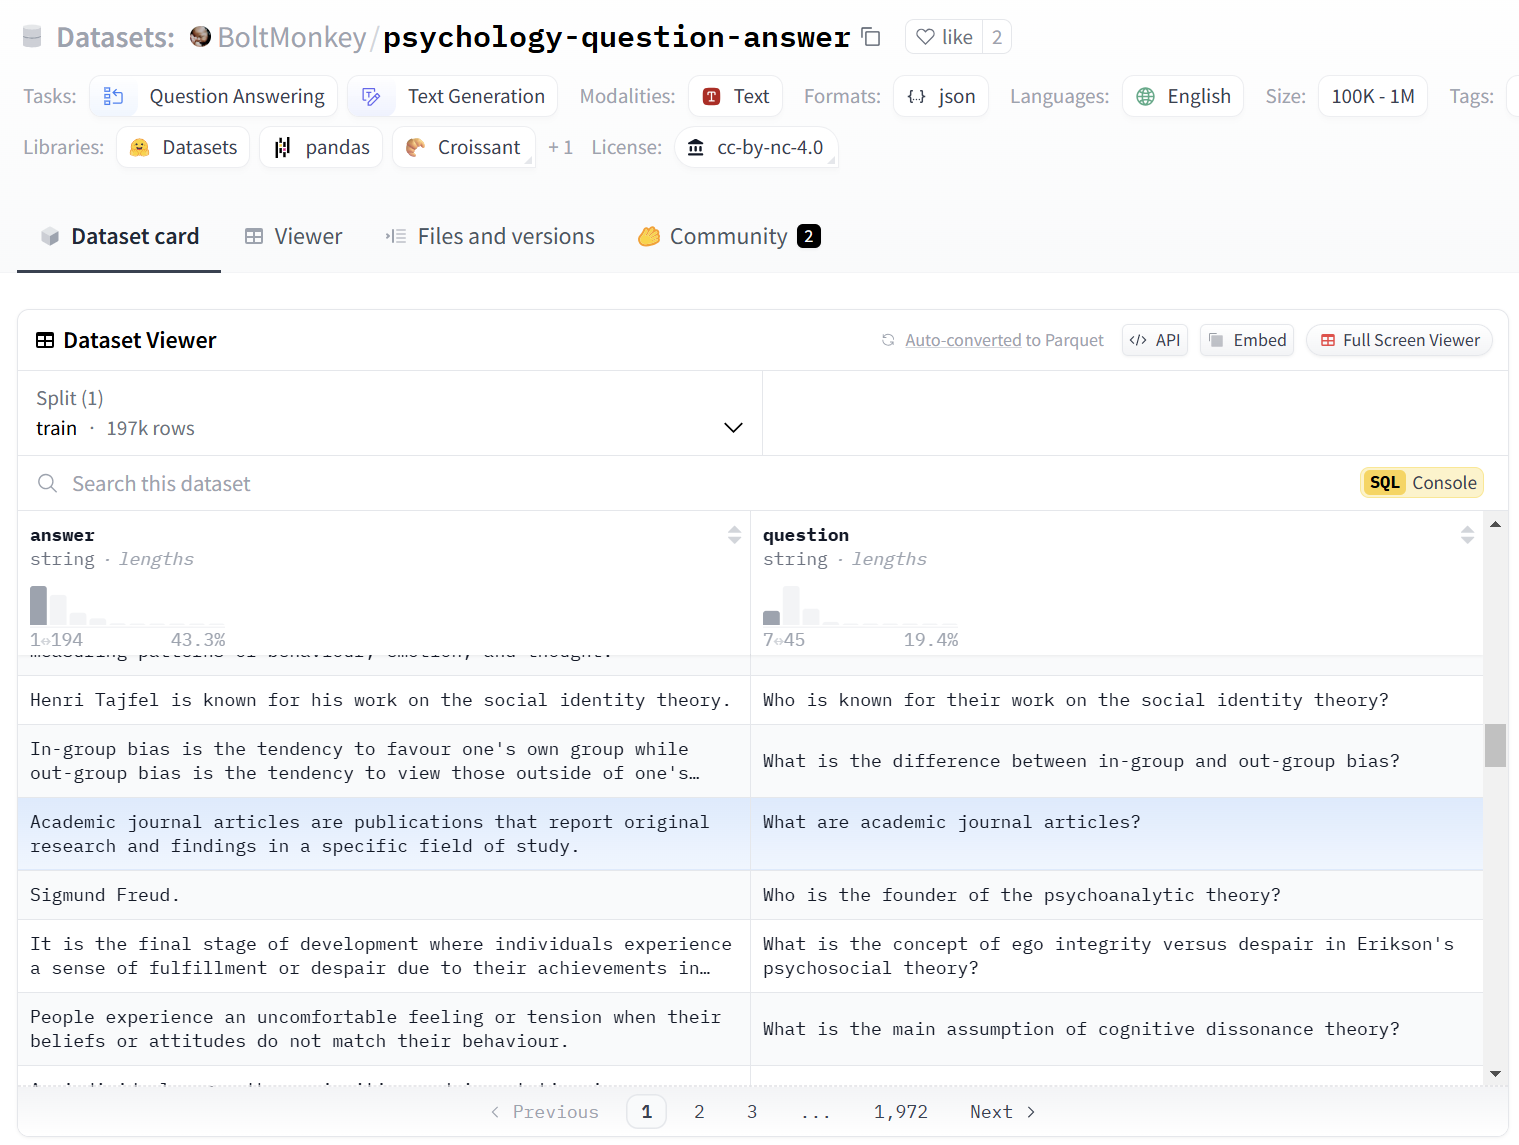

In [ ]:
from datasets import load_dataset

dataset = load_dataset("BoltMonkey/psychology-question-answer", split = "train")
dataset = dataset.map(formatting_prompts_func, batched = True,)

README.md:   0%|          | 0.00/1.32k [00:00<?, ?B/s]

train.json:   0%|          | 0.00/74.9M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/197180 [00:00<?, ? examples/s]

Map:   0%|          | 0/197180 [00:00<?, ? examples/s]

In [ ]:
dataset

Dataset({
    features: ['answer', 'question', 'text'],
    num_rows: 197180
})

In [ ]:
import pprint
#Here are a few examples of what the data looks like
pprint.pprint(dataset[250])
pprint.pprint(dataset[260])
pprint.pprint(dataset[270])

{'answer': "Sympathy involves feeling sorry for someone's situation, while "
           "empathy involves stepping into another person's shoes and feeling "
           'what they feel.',
 'question': 'What is the difference between sympathy and empathy?',
 'text': '\n'
         '### Instruction:\n'
         '\n'
         '\n'
         '### Input:\n'
         'What is the difference between sympathy and empathy?\n'
         '\n'
         '### Response:\n'
         "Sympathy involves feeling sorry for someone's situation, while "
         "empathy involves stepping into another person's shoes and feeling "
         'what they feel.<|end_of_text|>'}
{'answer': 'Carl Rogers was a humanistic psychologist who believed in '
           'client-centered therapy, where the therapist provides support '
           'without judgement and helps clients find their own solutions to '
           'their problems.',
 'question': 'Who is Carl Rogers and what was his contribution to psychology?',
 'text': 

**Step 5: Configure the Training Parameters**

Now let's define the training parameters, including the model, tokenizer, and dataset, along with key training settings like batch size, gradient accumulation steps, learning rate, and maximum training steps. The TrainingArguments specify additional configurations, such as optimization with the AdamW optimizer, weight decay, and logging frequency.

* **Learning Rate:** Controls the speed at which the model updates during training.

* **Batch Size:** The number of samples processed in one iteration.

* **Epochs:** The number of times the model passes through the entire training dataset.

* **Logging Directory:** Specifies where to store training logs, useful for monitoring progress.

The Trainer simplifies the configuration and management of the fine-tuning process, ensuring a balanced and efficient setup. We did 60 steps to make finetuning faster, **but you can set num_train_epochs=1 for a full run, and turn off max_steps=None**.

In [ ]:
from trl import SFTTrainer
from transformers import TrainingArguments

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = dataset,
    dataset_text_field = "text",
    max_seq_length = max_seq_length,
    dataset_num_proc = 2,
    packing = True,
    args = TrainingArguments(
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 4,
        warmup_steps = 5,
        max_steps = 60,
        learning_rate = 2e-4,
        fp16 = not torch.cuda.is_bf16_supported(),
        bf16 = torch.cuda.is_bf16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
    ),
)

Generating train split: 0 examples [00:00, ? examples/s]

max_steps is given, it will override any value given in num_train_epochs


**Step 6: Start Training**

The line `trainer_stats = trainer.train() `initiates the fine-tuning process using the SFTTrainer. It triggers the training loop, where the model learns from the provided dataset based on the configurations defined earlier. we can see the loss is decreasing during training, this means the model is learning and improving its performance. In machine learning, loss represents how well the model's predictions match the actual target values. When the loss decreases over time, it indicates that the model is gradually adjusting its parameters to make more accurate predictions.

In [ ]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 6,911 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 2 | Gradient Accumulation steps = 4
\        /    Total batch size = 8 | Total steps = 60
 "-____-"     Number of trainable parameters = 41,943,040
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Step,Training Loss
1,1.836700
2,1.841700
3,1.707600
4,1.675300
5,1.677400
6,1.582100
7,1.465500
8,1.462600
9,1.498500
10,1.425000


**Step 7: Perform Inference with the Fine-Tuned Model to Evaluate output**

When we generate text with the fine-tuned model, the output typically includes the full structure of the input prompt along with the model's response. For instance, the output for this example looks like this:

In [ ]:
FastLanguageModel.for_inference(model) # For faster Inference

inputs = tokenizer(
[
    chat_prompt.format(
        "", # instruction - leave this blank!
        "Who is the founder of the psychoanalytic theory?", # input
        "", # output - leave this blank!
    )
], return_tensors = "pt").to("cuda")

outputs = model.generate(**inputs, max_new_tokens = 64, use_cache = True)
tokenizer.batch_decode(outputs)

['<|begin_of_text|>\n### Instruction:\n\n\n### Input:\nWho is the founder of the psychoanalytic theory?\n\n### Response:\nSigmund Freud is the founder of the psychoanalytic theory.<|end_of_text|>']

To extract and print only the response part of the output, we can modify your code to process the decoded output string. Here's the new code:

In [ ]:
FastLanguageModel.for_inference(model)

inputs = tokenizer(
    [
        chat_prompt.format(
            "",  # instruction
            "Who is the founder of the psychoanalytic theory? ",  # input
            "",  # output
        )
    ],
    return_tensors="pt"
).to("cuda")

outputs = model.generate(**inputs, max_new_tokens=64, use_cache=True)
decoded_output = tokenizer.batch_decode(outputs)[0]  # Decode the output

# Extracting the response part
response = decoded_output.split("### Response:")[-1].strip()  # Get text after "### Response:"
response = response.split("<|end_of_text|>")[0].strip()  # Remove the end token if present

print(response)


Sigmund Freud.


**Comparing response to dataset answer:**

As you can see, when we asked the same question twice, the model gave the same answer but written in different ways. This shows that the model is relying on the dataset while also being able to generalize.

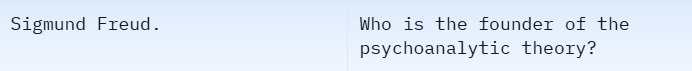

In [ ]:

FastLanguageModel.for_inference(model)

inputs = tokenizer(
    [
        chat_prompt.format(
            "",  # instruction
            "Who proposed the concept of self-efficacy?",  # input
            "",  # output
        )
    ],
    return_tensors="pt"
).to("cuda")

outputs = model.generate(**inputs, max_new_tokens=64, use_cache=True)
decoded_output = tokenizer.batch_decode(outputs)[0]

response = decoded_output.split("### Response:")[-1].strip()
response = response.split("<|end_of_text|>")[0].strip()

print(response)

Albert Bandura proposed the concept of self-efficacy, which refers to an individual's belief in their ability to succeed in a particular task or situation.


**Comparing response to dataset answer:**

in this example, the model used the knowledge from the dataset but with variation and extension. This behavior demonstrates that the model has genuinely learned patterns and concepts from the data rather than merely memorizing it.

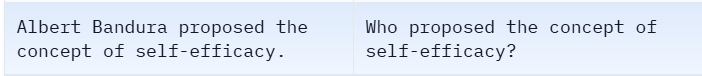

In [ ]:
FastLanguageModel.for_inference(model)

inputs = tokenizer(
    [
        chat_prompt.format(
            "",  # instruction
            "Who is known for their work on classical conditioning?",  # input
            "",  # output
        )
    ],
    return_tensors="pt"
).to("cuda")

outputs = model.generate(**inputs, max_new_tokens=64, use_cache=True)
decoded_output = tokenizer.batch_decode(outputs)[0]

response = decoded_output.split("### Response:")[-1].strip()
response = response.split("<|end_of_text|>")[0].strip()

print(response)

Ivan Pavlov is known for his work on classical conditioning.


**Comparing response to dataset answer:**

The model is also answering in the same style by keeping the responses short and straight to the point. This consistency in style indicates that the model not only learned the content from the dataset but also the tone and structure of the responses, allowing it to generate answers that align with the desired format.

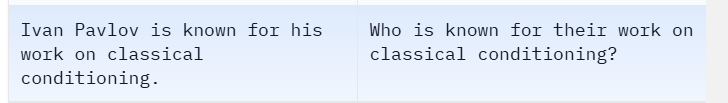

**Step 7: Saving, loading finetuned models**

In [ ]:
model.save_pretrained("lora_model")
tokenizer.save_pretrained("lora_model")
# model.push_to_hub("your_name/lora_model", token = "...") # If you want to save online
# tokenizer.push_to_hub("your_name/lora_model", token = "...") # If you want to save online

('lora_model/tokenizer_config.json',
 'lora_model/special_tokens_map.json',
 'lora_model/tokenizer.json')

In [ ]:
#Let's zip our model folder
import shutil
import os
folder_path = "/content/lora_model"
zip_file_path = "/content/lora_model.zip"

shutil.make_archive(zip_file_path.replace(".zip", ""), 'zip', folder_path)

'/content/lora_model.zip'

In [ ]:
#Now if we want to use our model again we can just load it:

if False:
    from unsloth import FastLanguageModel
    model, tokenizer = FastLanguageModel.from_pretrained(
        model_name = "lora_model", #model folder
        max_seq_length = max_seq_length,
        dtype = dtype,
        load_in_4bit = load_in_4bit,
    )
    FastLanguageModel.for_inference(model)

In [ ]:
chat_prompt = """
### Instruction:
{}

### Input:
{}

### Response:
{}"""

In [ ]:
inputs = tokenizer(
    [
        chat_prompt.format(
            "",  # instruction
            "What is heuristics?",  # input
            "",  # output
        )
    ],
    return_tensors="pt"
).to("cuda")

outputs = model.generate(**inputs, max_new_tokens=64, use_cache=True)
decoded_output = tokenizer.batch_decode(outputs)[0]

response = decoded_output.split("### Response:")[-1].strip()
response = response.split("<|end_of_text|>")[0].strip()

print(response)

Heuristics are mental shortcuts or rules of thumb that people use to make decisions or solve problems quickly and efficiently. They are often based on prior experience or intuitive judgments, and can lead to errors or biases in judgment.


**Comparing response to dataset answer:**

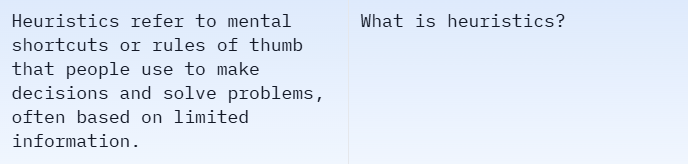

And that's a wrap! Keep exploring, keep learning, and enjoy the process.